In [3]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
rf.stylely()

import numpy as np
from scipy.special import ellipk

In [4]:

def cpw_capacitance_inductance(w, s, l, epsilon_r):
    """
    Calculates the capacitance and inductance of a CPW resonator.
    
    Parameters:
    w (float): Width of the center conductor (m)
    s (float): Gap between the center conductor and ground planes (m)
    l (float): Length of the CPW resonator (m)
    epsilon_r (float): Relative permittivity of the substrate
    
    Returns:
    C (float): Capacitance of the CPW resonator (F)
    L (float): Inductance of the CPW resonator (H)
    """
    
    # Permittivity of free space
    epsilon_0 = 8.854e-12
    
    # Permeability of free space
    mu_0 = 4 * np.pi * 1e-7
    
    # Effective dielectric constant
    epsilon_eff = (epsilon_r + 1) / 2
    
    # Calculation of the elliptic integrals
    k = w / (w + 2 * s)
    k_prime = np.sqrt(1 - k**2)
    
    K_k = ellipk(k)
    K_k_prime = ellipk(k_prime)
    
    # Capacitance per unit length
    C_l = 4 * epsilon_0 * epsilon_eff * K_k / K_k_prime
    
    # Inductance per unit length
    L_l = mu_0 * K_k_prime / (4 * K_k)
    
    # Total capacitance and inductance
    C = C_l * l
    L = L_l * l
    
    return C, L
def cl_ll(w, s, epsilon_r):
    
    # Permittivity of free space
    epsilon_0 = 8.854e-12
    
    # Permeability of free space
    mu_0 = 4 * np.pi * 1e-7
    
    # Effective dielectric constant
    epsilon_eff = (epsilon_r + 1) / 2
    
    # Calculation of the elliptic integrals
    k = w / (w + 2 * s)
    k_prime = np.sqrt(1 - k**2)
    
    K_k = ellipk(k)
    K_k_prime = ellipk(k_prime)
    
    # Capacitance per unit length
    C_l = 4 * epsilon_0 * epsilon_eff * K_k / K_k_prime
    
    # Inductance per unit length
    L_l = mu_0 * K_k_prime / (4 * K_k)
    
    return C_l, L_l

In [52]:

# Example usage
w = 10e-6  # Center conductor width (m)
s = 6e-6  # Gap between center conductor and ground planes (m)
l = 7.500e-3 # Length of the CPW resonator (m)
epsilon_r = 11.9  # Relative permittivity of the substrate

capacitance, inductance = cpw_capacitance_inductance(w, s, l, epsilon_r)
c_l, l_l = cl_ll(w, s, epsilon_r)
c_danilo = c_l*l
l_danilo = l_l*l
v_ph = 1/np.sqrt(c_l*l_l)
frequency = v_ph / 2/l
print(f"Capacitance: {capacitance:.3e} F")
print(f"Inductance: {inductance:.3e} H")
print(f"Expected resonator frequency: {frequency / 1e9:.3e} GHz")

Capacitance: 1.228e-12 F
Inductance: 3.288e-09 H
Expected resonator frequency: 7.870e+00 GHz


In [10]:
fl_traits = pd.read_csv("single_clockmons_readout_structure.csv").values[0][1:]

In [21]:
Z0 = CPW( w = 10e-6, s = 6e-6, ep_r = 11.9).z0[0].real

unloaded_readout_res_frequency = frequency
l_r = Z0*pi/(4*pi*unloaded_readout_res_frequency)
c_r = 1/((2*pi*unloaded_readout_res_frequency)**2*l_r)

In [55]:
# Building the circuit
Z_0 = 50
freq = rf.Frequency(start=2.5, stop=8, unit='GHz', npoints=10001)
port1 = rf.Circuit.Port(freq, 'port1', z0=Z_0) # Launcher 1
port2 = rf.Circuit.Port(freq, 'port2', z0=Z_0) # Launcher 2

# Circuit element generators
# CPW generator object
cpw = CPW(frequency = freq, w = 10e-6, s = 6e-6, ep_r = 11.9)
# Capacitor generator object
capacitor = rf.DefinedGammaZ0(freq, z0=50).capacitor
inductor = rf.DefinedGammaZ0(freq, z0=50).inductor

# Circuit element definitions
tl_0 = cpw.line(d = fl_traits[0], unit='deg', name='trans_line0')
tl_1 = cpw.line(d = fl_traits[1], unit='deg', name='trans_line1')
tl_2 = cpw.line(d = fl_traits[2], unit='deg', name='trans_line2')
tl_3 = cpw.line(d = fl_traits[3], unit='deg', name='trans_line3')
tl_4 = cpw.line(d = fl_traits[3], unit='deg', name='trans_line4')

rr_0 = cpw.line(d = l, unit = 'm', name='rr_0')
rr_1 = cpw.line(d = 1.5e-3, unit = 'm', name='rr_1')
rr_2 = cpw.line(d = 1.7e-3, unit = 'm', name='rr_2')
rr_3 = cpw.line(d = 1.8e-3, unit = 'm', name='rr_3')

c_r0 = capacitor(1e-15, name='C_r0')
c_r0_shunt = capacitor(c_r, name = "C_r0_shunt")
c_danilo_shunt = capacitor(c_danilo, name = "C_r0_shunt")
l_danilo_shunt = inductor(l_danilo, name = "L_r0_shunt")

c_r1 = capacitor(10e-15, name='C_r1') 
c_r2 = capacitor(10e-15, name='C_r2') 
c_r3 = capacitor(10e-15, name='C_r3') 

gnd0 = rf.Circuit.Ground(freq, name='gnd1') # Reference to ground
gnd1 = rf.Circuit.Ground(freq, name='gnd2') # Reference to ground
gnd2 = rf.Circuit.Ground(freq, name='gnd3') # Reference to ground
gnd3 = rf.Circuit.Ground(freq, name='gnd4') # Reference to ground

# Connections
# A connection list of nodes. Each node is itself a list of element connected to it.
# Each element connection to a specific node is defined by a tuple (element, 'port-id').
# 'port-id' can be either 0 or 1 for most lumped elements (except for n-port elements like tees)
# and it indicates which port is connected to the node.
cnx = [
    [(port1, 0), (tl_0, 0)],
    [(tl_0, 1), (c_r0, 0), (tl_1, 0)],
    [(tl_1, 1), (c_r1, 0), (tl_2, 0)],
    [(tl_2, 1), (c_r2, 0), (tl_3, 0)],
    [(tl_3, 1), (c_r3, 0), (tl_4, 0)],
    [(tl_4, 1), (port2, 0)],
    [(c_r0, 1),  (l_danilo_shunt, 0)],
    [(c_r1, 1), (rr_1, 0)],
    [(c_r2, 1), (rr_2, 0)],
    [(c_r3, 1), (rr_3, 0)],
    [(l_danilo_shunt, 1),(c_danilo_shunt, 0)],
    [(c_danilo_shunt, 1), (gnd0, 0)],
    # [(c_r0_shunt, 1), (gnd0, 0), (l_r0_shunt, 1)],
    [(rr_1, 1), (gnd1, 0)],
    [(rr_2, 1), (gnd2, 0)],
    [(rr_3, 1), (gnd3, 0)]
]
cir = rf.Circuit(cnx)

2-Port Network: '',  2.5-8.0 GHz, 10001 pts, z0=[50.+0.j 50.+0.j]


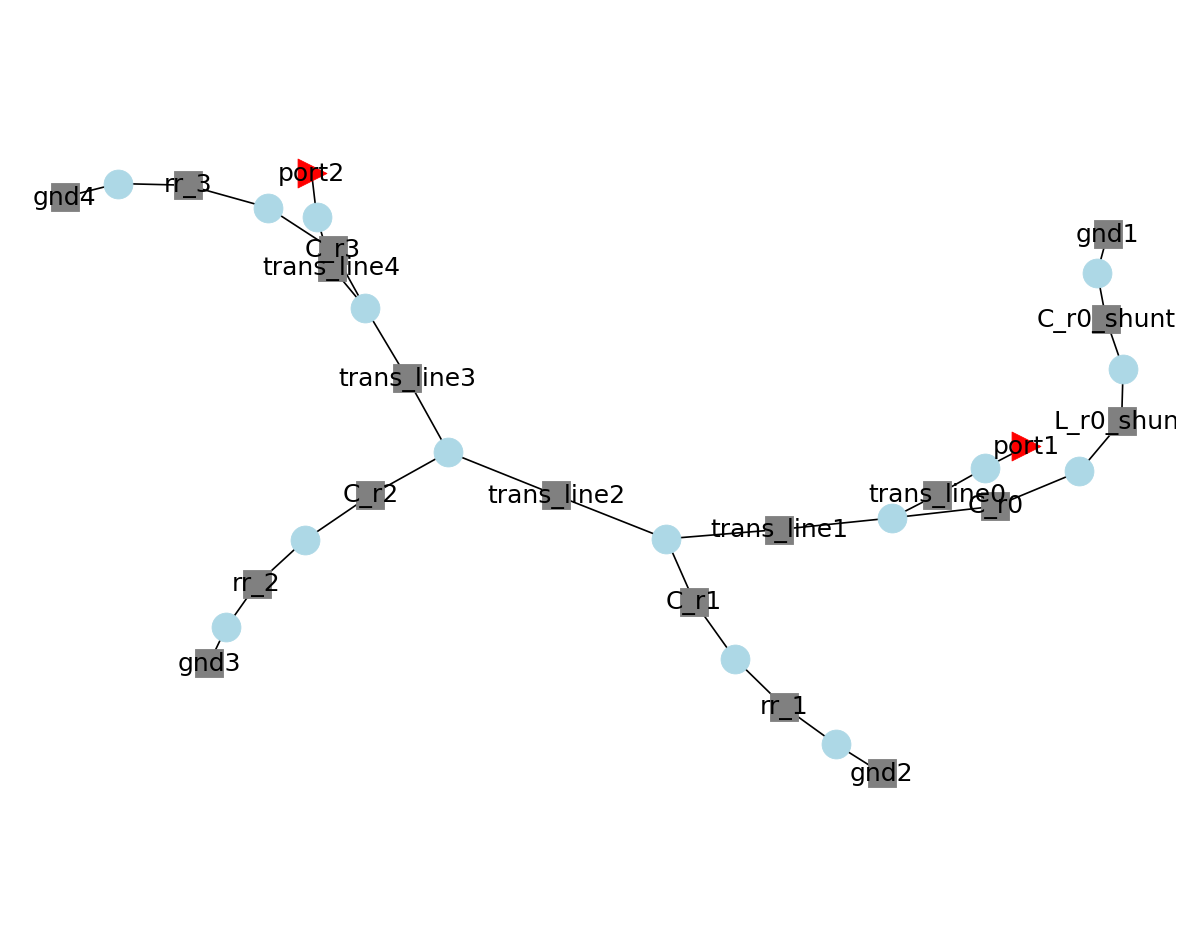

In [56]:
# Plot the network as a graph
cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

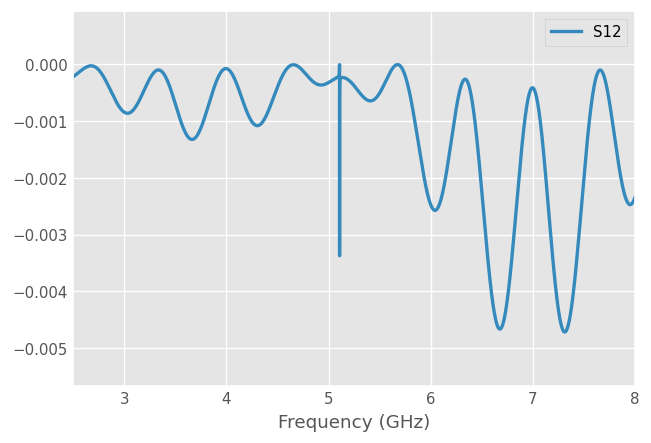

In [50]:
ntw.plot_s_db(m=0, n=1, lw=2)